In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%tensorflow_version 1.x
!pip uninstall -y keras-nightly
!pip install h5py==2.10.0
!pip install keras==2.2.5

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 5.2 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 336 kB 5.2 MB/s 
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [4]:
!pip3 uninstall keras-nightly
!pip3 uninstall -y tensorflow
!pip3 install keras==2.1.6
!pip3 install tensorflow==1.15.0
!pip3 install h5py==2.10.0

Found existing installation: tensorflow 1.15.2
Uninstalling tensorflow-1.15.2:
  Successfully uninstalled tensorflow-1.15.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 339 kB 5.2 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires keras<2.9,>=2.8.0rc0, but you have keras 2.1.6 which is incompatible.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 1.15.0 which is incompatible.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorflow-estimator<2.9,>=2.8, but you have tensorflow-estimator 1.15.1 which is incompatible.
Lookin

In [5]:
import os
os.chdir("/content/drive/MyDrive/Majorproject/finalmajor2022/finalyearproject/1_MASKRCNN")

In [6]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Root directory of the project
ROOT_DIR = "/content/drive/MyDrive/Majorproject/finalmajor2022/finalyearproject/1_MASKRCNN"

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


WEIGHTS_PATH = "/content/drive/MyDrive/Majorproject/finalmajor2022/finalyearproject/1_MASKRCNN/logs/object20210711T1316/mask_rcnn_object_0010.h5"


Using TensorFlow backend.


In [7]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 4  

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 70% confidence
    DETECTION_MIN_CONFIDENCE = 0.7

In [8]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "/DATASET/")
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [9]:

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        self.add_class("object", 1, "gidda")
        self.add_class("object", 2, "jaya")
        self.add_class("object", 3, "jyothi")
        self.add_class("object", 4, "m4")

        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
      
        annotations1 = json.load(open(os.path.join(dataset_dir, "finalannotated.json")))
        annotations = list(annotations1.values())  # don't need the dict keys

        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
           
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"gidda": 1,"jaya": 2,"jyothi": 3,"m4": 4}
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object", 
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
       
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):

        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [10]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
ROOT_DIR = "/content/drive/MyDrive/Majorproject/finalmajor2022/finalyearproject/1_MASKRCNN/DATASET"

def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = "/content/drive/MyDrive/Majorproject/finalmajor2022/finalyearproject/1_MASKRCNN/DATASET"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['jaya', 'm4', 'm4', 'gidda', 'jyothi', 'm4', 'm4', 'm4', 'jyothi', 'jyothi']
numids [2, 4, 4, 1, 3, 4, 4, 4, 3, 3]
objects: ['m4', 'gidda', 'm4', 'jyothi', 'jaya', 'gidda', 'jaya', 'jyothi', 'jyothi', 'jaya']
numids [4, 1, 4, 3, 2, 1, 2, 3, 3, 2]
objects: ['m4', 'jaya', 'jyothi', 'jaya', 'jaya', 'gidda', 'jaya', 'm4', 'm4', 'jyothi']
numids [4, 2, 3, 2, 2, 1, 2, 4, 4, 3]
objects: ['jaya', 'gidda', 'gidda', 'm4', 'jyothi', 'gidda', 'm4', 'gidda', 'm4', 'jyothi']
numids [2, 1, 1, 4, 3, 1, 4, 1, 4, 3]
objects: ['m4', 'jyothi', 'jyothi', 'jaya', 'jaya', 'jyothi', 'm4', 'gidda', 'jaya', 'm4']
numids [4, 3, 3, 2, 2, 3, 4, 1, 2, 4]
objects: ['jaya', 'm4', 'm4', 'gidda', 'jyothi', 'm4', 'jaya', 'jyothi', 'jaya', 'gidda']
numids [2, 4, 4, 1, 3, 4, 2, 3, 2, 1]
objects: ['m4', 'gidda', 'gidda', 'gidda', 'jyothi', 'jyothi', 'jyothi', 'm4', 'jaya', 'jaya']
numids [4, 1, 1, 1, 3, 3, 3, 4, 2, 2]
objects: ['m4', 'jyothi', 'jaya', 'jaya', 'm4', 'jyothi', 'gidda', 'gidda', 'gidda', 'gidda']
nu

In [11]:
config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [12]:
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/drive/MyDrive/Majorproject/finalmajor2022/finalyearproject/1_MASKRCNN/logs/object20210711T1316/mask_rcnn_object_0010.h5






Re-starting from epoch 10


In [13]:
#Now, we are ready for testing our model on any image.

#RUN DETECTION
image_id = random.choice(dataset.image_ids)

print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

image id is : 70
image ID: object.101471.png (70) /content/drive/MyDrive/Majorproject/finalmajor2022/finalyearproject/1_MASKRCNN/DATASET/val/101471.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


gt_class_id              shape: (10,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (10, 4)               min:  122.00000  max:  990.00000  int32
gt_mask                  shape: (1024, 1024, 10)      min:    0.00000  max:    1.00000  uint8


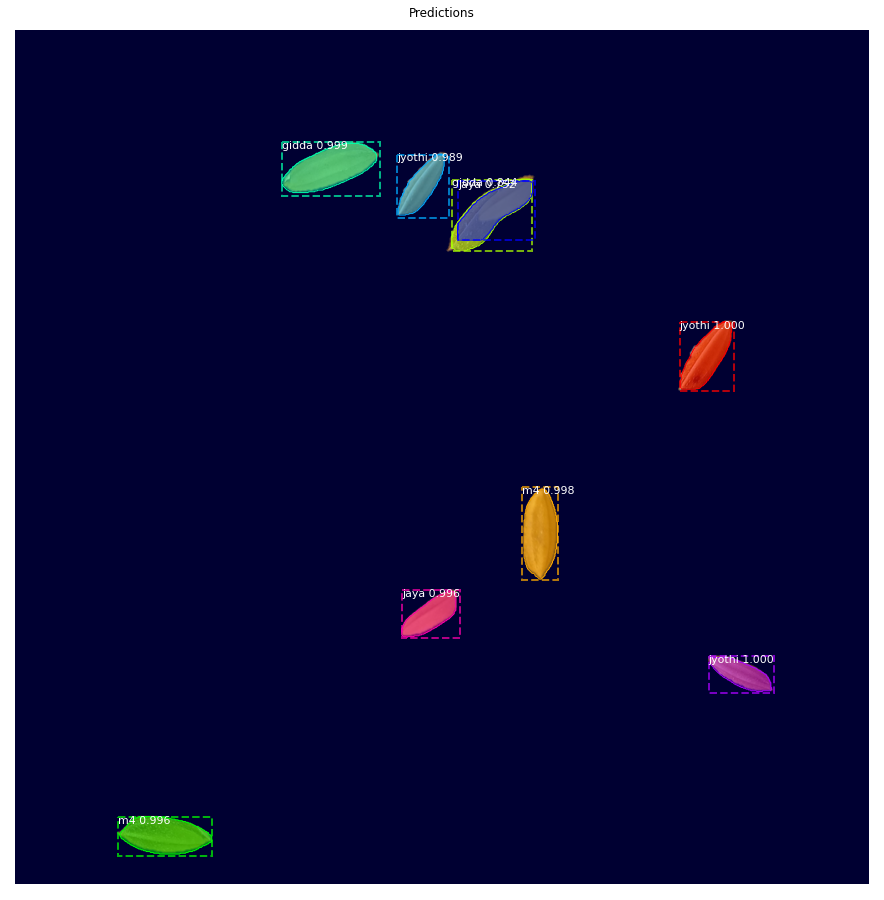

In [14]:

# Display results
x = get_ax(1)
r = results[0]
ax = plt.gca()
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=ax, title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


1
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -103.90000  max:  131.30000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


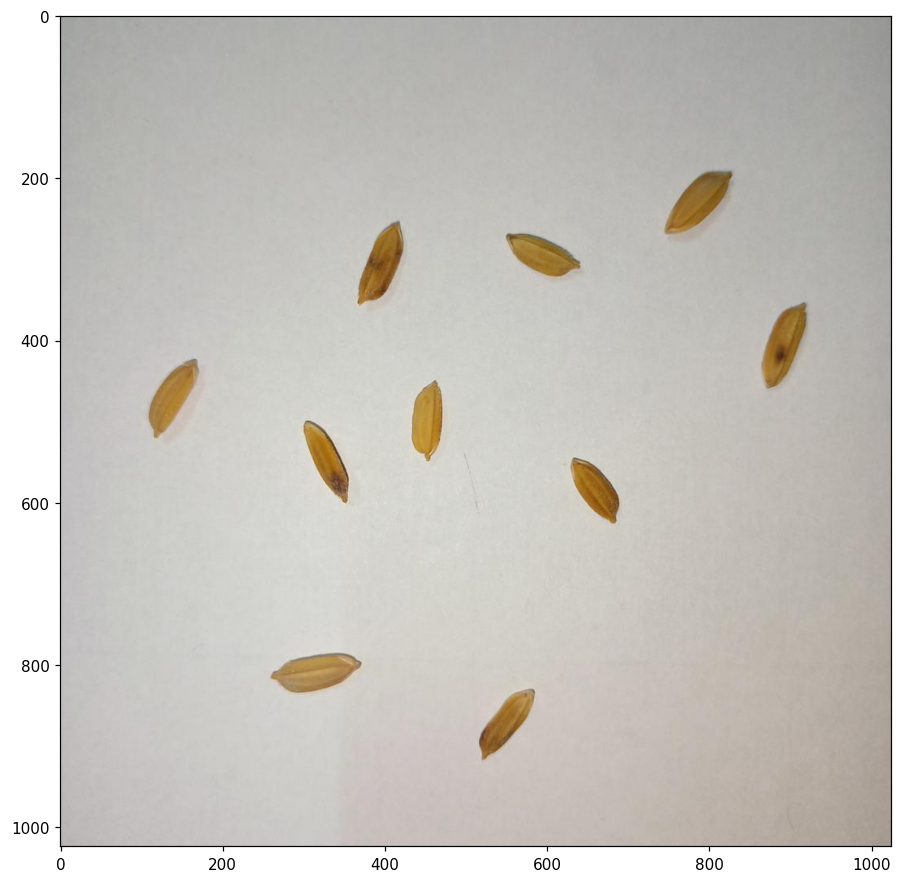

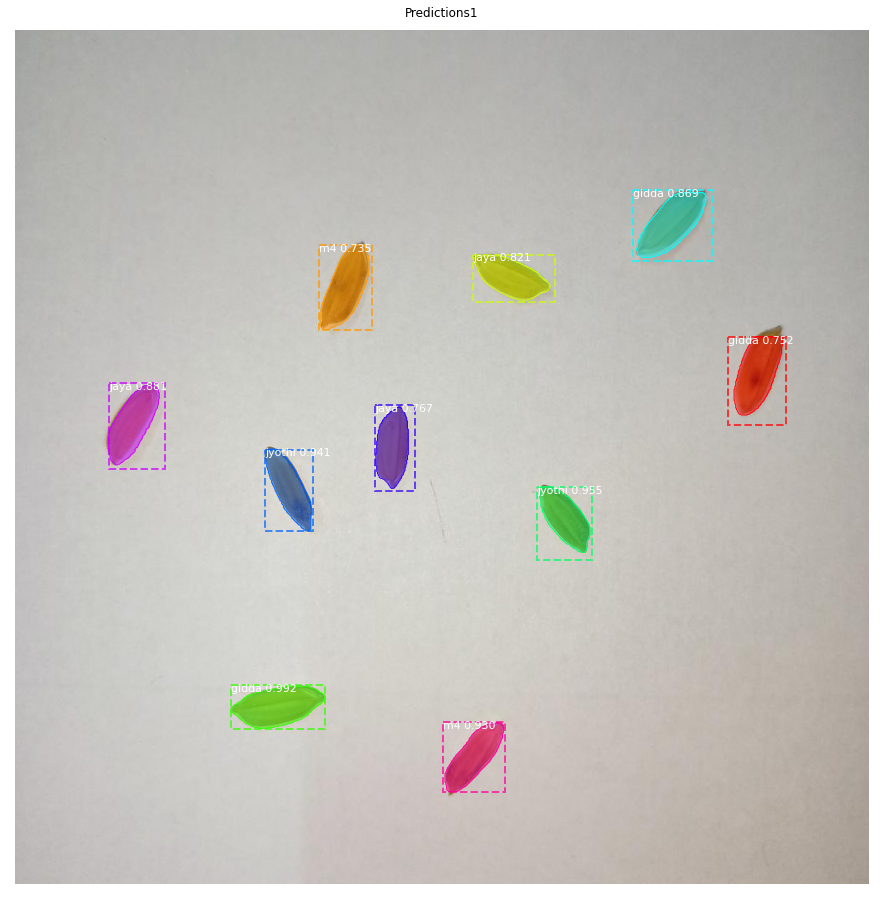

In [15]:

from matplotlib.pyplot import figure

path_to_new_image = '/content/drive/MyDrive/Majorproject/finalmajor2022/finalyearproject/testdataimg/test009.jpg'
image1 = mpimg.imread(path_to_new_image)
# Run object detection

print(len([image1]))
results1 = model.detect([image1], verbose=1)

figure(figsize=(10, 10), dpi=110)
plt.imshow(image1)

# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")